<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/period-and-revolution-time-rigid-pendulum-Vinnie369/blob/main/period_and_revolution_time_rigid_pendulum_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting the period of the rigid pendulum

### Pseudocode
1. **Import needed modules:** `numpy` for special functions and linear algebra; `matplotlib.pyplot` for plotting; `scipy.integrate` for `solve_ivp` for finding the pendulum trajectory, and `quad` for integration.
2. **Define ODE function and the integrand:** [add details]
3. **Create utilities:** some basic plotting functions...
4. **Extract the period using the integral:** ...
5. **Extract the period using the differential equation:**...
6. **Plot both results and compare:**...

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

### Define ODE function and the integrand

1. `rigid_pendulum_ode(t, y, omega_0=1)` gives the differential equation for the rigid pendulum in the form needed for `solve_ivp`.
2. `period_integrand(theta, theta_0, omega_0=1)` gives the integrand in a form that can used with `quad`.

In [2]:
# define the rigid pendulum ODE and the integrand for integration with quad

# rigid pendulum ode
def rigid_pendulum_ode(t, y, omega_0=1.0):
    """y = [theta, ang_vel]; theta'' + omega_0^2 sin(theta) = 0"""
    theta, ang_vel = y
    return [ang_vel, -(omega_0**2) * np.sin(theta)]

# energy per unit inertia e = 1/2 v^2 + ω0^2 (1 - cos θ)
def energy_per_I(theta, ang_vel, omega_0=1.0):
    return 0.5 * ang_vel**2 + (omega_0**2) * (1 - np.cos(theta))

# convenience: separatrix energy (θ at the top, π)
def separatrix_energy(omega_0=1.0):
    return 2.0 * (omega_0**2)  # e_sep


### Create utilities

1. `basic_plot(x, y, xlabel=None, ylabel=None, figsize=(3,3))` creates a simple plot for fast evaluation of data, visually.
2. `ang_vel_zero_event(t, y, omega_0=1)` creates an event for `solve_ivp` (`ang_vel=0`).
3. `extract_period_int(n_points, eps=1e-3, omega_0=1)` extracts the period on a mesh of `theta_0` using the integral method.
4. `extract_period_ode(n_points, eps=1e-3, omega_0=1)` extracts the perido with `solve_ivp` events.

In [3]:
# create utilities

# basic plotting (kept from your version)
def basic_plot(x, y, xlabel=None, ylabel=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt.show()

# Events for solve_ivp
def ang_vel_zero_event(t, y, omega_0=1.0):
    """
    Turning points: v = 0 (we will filter to maxima using acceleration sign).
    """
    return y[1]
ang_vel_zero_event.terminal = False
ang_vel_zero_event.direction = 0

def revolution_event(theta0):
    """
    Return an event function that triggers when θ(t) - θ0 = +2π.
    """
    def ev(t, y, omega_0=1.0):
        return y[0] - theta0 - 2*np.pi
    ev.terminal = True
    ev.direction = 1
    return ev

# Period via events (oscillation regime)
def extract_period_ode_vs_angvel(ang_vel_0_list, theta0=0.0, omega_0=1.0):
    """
    Return arrays (ang_vel_0_list, T_list) using two successive maxima detected by v=0 events.
    """
    e_sep = separatrix_energy(omega_0)
    T_list = []
    for v0 in ang_vel_0_list:
        e0 = 0.5 * v0**2
        if e0 >= e_sep or abs(e0 - e_sep) < 1e-3:
            T_list.append(np.nan)  # not oscillatory or too close to separatrix
            continue

        y0 = [theta0, v0]
        sol = solve_ivp(lambda t,y: rigid_pendulum_ode(t,y,omega_0),
                        [0, 120.0], y0,
                        events=lambda t,y: ang_vel_zero_event(t,y,omega_0),
                        max_step=0.05, rtol=1e-7, atol=1e-9, dense_output=False)

        t_ev = sol.t_events[0]
        if t_ev is None or len(t_ev) < 3:
            T_list.append(np.nan)
            continue

        # keep only peaks (acc < 0) at event times
        peaks = []
        for te in t_ev:
            # nearest stored θ to estimate acceleration sign
            idx = np.searchsorted(sol.t, te)
            theta_here = sol.y[0, max(0, min(idx, sol.y.shape[1]-1))]
            acc = -(omega_0**2)*np.sin(theta_here)
            if acc < 0:
                peaks.append(te)
            if len(peaks) >= 2:
                break

        T_list.append(peaks[1] - peaks[0] if len(peaks) >= 2 else np.nan)

    return np.array(ang_vel_0_list), np.array(T_list)

# Revolution time via events (rotation regime)
def extract_Trev_ode_vs_angvel(ang_vel_0_list, theta0=0.0, omega_0=1.0):
    """
    Return arrays (ang_vel_0_list, Trev_list) using event θ-θ0=+2π.
    """
    e_sep = separatrix_energy(omega_0)
    Trev_list = []
    ev = revolution_event(theta0)
    for v0 in ang_vel_0_list:
        e0 = 0.5 * v0**2
        if e0 < e_sep or abs(e0 - e_sep) < 1e-3:
            Trev_list.append(np.nan)
            continue

        y0 = [theta0, v0]
        sol = solve_ivp(lambda t,y: rigid_pendulum_ode(t,y,omega_0),
                        [0, 240.0], y0,
                        events=lambda t,y: ev(t,y,omega_0),
                        max_step=0.02, rtol=1e-7, atol=1e-9, dense_output=False)

        Trev_list.append(sol.t_events[0][0] if len(sol.t_events[0]) else np.nan)
    return np.array(ang_vel_0_list), np.array(Trev_list)

# Integral formulas
def T_from_integral(v0, theta0=0.0, omega_0=1.0):
    """
    Period for oscillations via integral; NaN in rotation regime.
    """
    e0 = 0.5*v0**2
    e_sep = separatrix_energy(omega_0)
    if e0 >= e_sep:
        return np.nan

    c = 1 - e0/(omega_0**2)
    c = min(max(c, -1.0), 1.0)
    theta_max = np.arccos(c)

    def integrand(theta):
        val = 2*(e0 - (omega_0**2)*(1 - np.cos(theta)))
        return 1/np.sqrt(val) if val > 0 else np.inf

    val, _ = quad(integrand, 0.0, theta_max, epsabs=1e-9, epsrel=1e-9, limit=200)
    return 4*val

def Trev_from_integral(v0, theta0=0.0, omega_0=1.0):
    """
    Revolution time for rotation via integral; NaN in oscillation regime.
    """
    e0 = 0.5*v0**2
    e_sep = separatrix_energy(omega_0)
    if e0 < e_sep:
        return np.nan

    def integrand(theta):
        val = 2*(e0 - (omega_0**2)*(1 - np.cos(theta)))
        return 1/np.sqrt(val) if val > 0 else np.inf

    val, _ = quad(integrand, 0.0, 2*np.pi, epsabs=1e-9, epsrel=1e-9, limit=400)
    return val

def extract_integral_vs_angvel(ang_vel_0_list, theta0=0.0, omega_0=1.0):
    """
    Return arrays for both T and T_rev computed via integrals.
    """
    T_list    = np.array([T_from_integral(v0, theta0, omega_0)   for v0 in ang_vel_0_list])
    Trev_list = np.array([Trev_from_integral(v0, theta0, omega_0) for v0 in ang_vel_0_list])
    return np.array(ang_vel_0_list), T_list, Trev_list

# define function to extract period on a mesh of theta_0 using the integral method
def extract_period_int(n_points, eps=1e-3, omega_0=1):
    """
    Return arrays (theta_0_list, T_list) using the integral formula.
    """
    theta_0_list = np.linspace(eps, np.pi - eps, n_points)
    # convert from initial angle theta_0 to initial ang vel v0 assuming v_0 = 0
    v_0_list = [np.sqrt(2*omega_0**2*(1 - np.cos(theta_0))) for theta_0 in theta_0_list]
    T_list = [T_from_integral(v0, theta0=0.0, omega_0=omega_0) for v0 in v_0_list]
    return theta_0_list, T_list

# define function to extract the period using solve_ivp events
def extract_period_ode(n_points, eps=1e-3, omega_0=1):
    """
    Return arrays (theta_0_list, T_list) using the solve_ivp events.
    """
    theta_0_list = np.linspace(eps, np.pi - eps, n_points)
    # convert from initial angle theta_0 to initial ang vel v0 assuming v_0 = 0
    v_0_list = [np.sqrt(2*omega_0**2*(1 - np.cos(theta_0))) for theta_0 in theta_0_list]
    T_list = [extract_period_ode_vs_angvel([v0], theta0=0.0, omega_0=omega_0)[1][0] for v0 in v_0_list]
    return theta_0_list, T_list

### Testing the integration approach

In [4]:
# # test the integral
# theta_0 = np.pi/2 # initial angle
# omega_0 = 1 # natural frequency
# period, err = quad(period_integrand, 0, theta_0, args=(theta_0, omega_0))

# print(period / (2*np.pi))

In [5]:
# n_points = 50 # number of initial angles
# theta_0_list, period_list_int = extract_period_int(n_points) # extract period on mesh of theta_0
# basic_plot(theta_0_list, period_list_int, xlabel='theta_0', ylabel='period') # plot

### Test the `solve_ivp` approach

In [6]:
# # testing the solve_ivp + event approach

# # range of times for integrating
# t_min = 0
# t_max = 100
# t_span = [t_min, t_max] # time span for solve_ivp

# # state variable
# theta_0 = np.pi - 0.001 # initial angle
# y_0 = [theta_0, 0] # initial condition

# # parameters
# omega_0 = 1 # natural frequency

# # solve differential equation
# sol = solve_ivp(rigid_pendulum_ode, t_span, y_0, args=(omega_0,),
#                 max_step = 0.01,
#                 dense_output=True,
#                 events=ang_vel_zero_event
#                 )

# # output the extracted period
# period = np.mean(np.diff(sol.t_events))
# print(period)

# # quick plot
# t_plot = np.linspace(t_min, t_max, 1000)
# theta_plot = sol.sol(t_plot)[0]
# ang_vel_plot = sol.sol(t_plot)[1]
# basic_plot(t_plot, theta_plot, xlabel='t', ylabel='theta', figsize=(12,2))
# basic_plot(t_plot, ang_vel_plot, xlabel='t', ylabel='ang_vel', figsize=(12,2))

In [7]:
# n_points = 20 # number of theta_0 values
# theta_0_list_ode, period_list_ode = extract_period_ode(n_points)

In [8]:
# basic_plot(theta_0_list_ode, period_list_ode, xlabel='theta_0', ylabel='period',figsize=(3,3))

### Compare the period extracted in the two different ways

In [9]:
# extract period with the integral approach
n_points_int = 100 # number of initial angles
theta_0_list_int, period_list_int = extract_period_int(n_points_int) # extract period on mesh of theta_0

# extract the period with the aolve_ivp approach
n_points_ode = 20 # number of theta_0 values
theta_0_list_ode, period_list_ode = extract_period_ode(n_points_ode) # extract period on mesh of theta_0

/tmp/ipython-input-2154534104.py:111: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(integrand, 0.0, theta_max, epsabs=1e-9, epsrel=1e-9, limit=200)


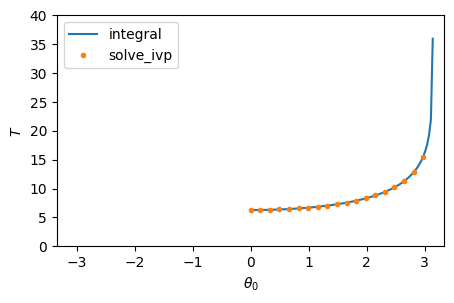

In [10]:
# plot them together
plt.figure(figsize=(5,3))
plt.plot(theta_0_list_int, period_list_int, label='integral')
plt.plot(theta_0_list_ode, period_list_ode, '.', label='solve_ivp')
plt.xlabel('$\\theta_0$')
plt.ylabel('$T$')
plt.xlim(-np.pi-0.2, np.pi+0.2)
plt.ylim(0, 40)
plt.legend()
plt.show()

### Rigid Pendulum: Period (T) and Revolution time (T_rev) vs initial angular velocity (ang_vel_0)

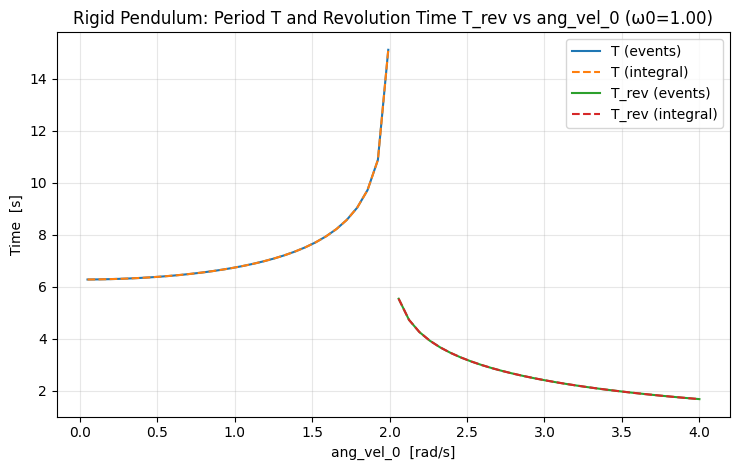

In [11]:
# Final sweep and labeled figure (vs ang_vel_0)
omega_0 = 1.0   # change if your notebook uses a different symbol/value
theta_0 = 0.0

ang_vel_0_grid = np.linspace(0.05, 4.0*omega_0, 60)

# Events
v_grid_evt_T,    T_evt    = extract_period_ode_vs_angvel(ang_vel_0_grid, theta0=theta_0, omega_0=omega_0)
v_grid_evt_Trev, Trev_evt = extract_Trev_ode_vs_angvel  (ang_vel_0_grid, theta0=theta_0, omega_0=omega_0)

# Integrals
v_grid_int, T_int, Trev_int = extract_integral_vs_angvel(ang_vel_0_grid, theta0=theta_0, omega_0=omega_0)

plt.figure(figsize=(7.5,4.8))
plt.title("Rigid Pendulum: Period T and Revolution Time T_rev vs ang_vel_0 (ω0={:.2f})".format(omega_0))
plt.xlabel("ang_vel_0  [rad/s]")
plt.ylabel("Time  [s]")
plt.plot(v_grid_evt_T, T_evt,                label="T (events)")
plt.plot(v_grid_int,   T_int,   linestyle="--", label="T (integral)")
plt.plot(v_grid_evt_Trev, Trev_evt,          label="T_rev (events)")
plt.plot(v_grid_int,    Trev_int, linestyle="--", label="T_rev (integral)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()